In [1]:
import os

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.utils import save_image

from tqdm import tqdm
import matplotlib.pyplot as plt
import copy
import numpy as np

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()

        self.fc1 = nn.Linear(latent_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, 1024)
        self.fc5 = nn.Linear(1024, 784)

        self.BN1 = nn.BatchNorm1d(256)
        self.BN2 = nn.BatchNorm1d(512)
        self.BN3 = nn.BatchNorm1d(1024)
        
        self.leaky_relu1 = nn.LeakyReLU(0.2)
        self.leaky_relu2 = nn.LeakyReLU(0.2)
        self.leaky_relu3 = nn.LeakyReLU(0.2)
        self.leaky_relu4 = nn.LeakyReLU(0.2)


        # Construct generator. You should experiment with your model,
        # but the following is a good start:
        #   Linear args.latent_dim -> 128
        #   LeakyReLU(0.2)
        
        #   Linear 128 -> 256
        #   Bnorm
        #   LeakyReLU(0.2)
        
        #   Linear 256 -> 512
        #   Bnorm
        #   LeakyReLU(0.2)
        
        #   Linear 512 -> 1024
        #   Bnorm
        #   LeakyReLU(0.2)
        
        #   Linear 1024 -> 784
        #   Output non-linearity

    def forward(self, z):
        # Generate images from z
        z = self.leaky_relu1(self.fc1(z))
        z = self.leaky_relu2(self.BN1(self.fc2(z)))
        z = self.leaky_relu3(self.BN2(self.fc3(z)))
        z = self.leaky_relu4(self.BN3(self.fc4(z)))
        z = torch.tanh(self.fc5(z))
        return z


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)
        self.leaky_relu1 = nn.LeakyReLU(0.2)
        self.leaky_relu2 = nn.LeakyReLU(0.2)

        # Construct distriminator. You should experiment with your model,
        # but the following is a good start:
        #   Linear 784 -> 512
        #   LeakyReLU(0.2)
        #   Linear 512 -> 256
        #   LeakyReLU(0.2)
        #   Linear 256 -> 1
        #   Output non-linearity

    def forward(self, img):
        # return discriminator score for img
        img = self.leaky_relu1(self.fc1(img))
        img = self.leaky_relu2(self.fc2(img))
        img = torch.sigmoid(self.fc3(img))
        return img

In [3]:
max_epoch = 200
batch_size = 64
learning_rate = 0.0002
latent_dim = 100
save_interval = 500
device = torch.device('cuda:0')

g_loss_list = []
d_loss_list = []
epoch_list = []

In [4]:
def train(dataloader, discriminator, generator, optimizer_G, optimizer_D):
    criterion = nn.BCELoss()
    for epoch in tqdm(range(max_epoch)):
        discriminator.train()
        generator.train()
        G_total_loss = 0.
        D_total_loss = 0.
        for i, (imgs, _) in enumerate(dataloader):

            imgs.cuda()
            imgs_real = torch.flatten(imgs, start_dim=1).cuda()
            
            batch_size = imgs_real.size(0)

            

            # Train Discriminator
            # -------------------
            for _ in range(5):
                z = torch.randn(batch_size, latent_dim).cuda()
                fake_images = generator(z)
            
                optimizer_D.zero_grad()

                real_preds = discriminator(imgs_real)
                real_labels = torch.ones(batch_size, 1).cuda()
                real_loss = criterion(real_preds, real_labels)

                fake_preds = discriminator(fake_images)
                fake_labels = torch.zeros(batch_size, 1).cuda()
                fake_loss = criterion(fake_preds, fake_labels)


                d_loss = real_loss + fake_loss
                d_loss.backward()
                optimizer_D.step()


            # Train Generator
            # ---------------
            imgs_gen = None
            for _ in range(2):
                z = torch.randn(batch_size, latent_dim).cuda()
                fake_images = generator(z)
                

                optimizer_G.zero_grad()

                fake_preds = discriminator(fake_images)
                real_labels = torch.ones(batch_size, 1).cuda()

                g_loss = criterion(fake_preds, real_labels)
                g_loss.backward()
                optimizer_G.step()

                imgs_gen = 0.5 * (fake_images + 1).view(batch_size, 1, 28, 28)

            batches_done = epoch * len(dataloader) + i
            if batches_done % save_interval == 0:
                # You can use the function save_image(Tensor (shape Bx1x28x28),
                # filename, number of rows, normalize) to save the generated
                # images, e.g.:
                save_image(imgs_gen[:25],'images_new/{}.png'.format(batches_done),nrow=5, normalize=True, value_range=(-1,1))
                
        epoch_list.append(epoch)        
        g_loss_list.append(g_loss)
        d_loss_list.append(d_loss)
        # print('G loss: {0}, D loss: {1}'.format(g_loss, d_loss))

In [5]:
os.makedirs('images_new', exist_ok=True)

In [6]:
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('./data/mnist', train=True, download=True,
                   transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(0.5, 0.5)])),
    batch_size=batch_size, shuffle=True)

In [7]:
generator = Generator(latent_dim).cuda()
discriminator = Discriminator().cuda()
optimizer_G = torch.optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)

In [ ]:
train(dataloader, discriminator, generator, optimizer_G, optimizer_D)

 98%|█████████▊| 197/200 [3:28:44<03:12, 64.10s/it]  

In [11]:
torch.save(generator.state_dict(), "mnist_generator_new.pt")

In [18]:
epoch_list = torch.tensor(epoch_list, device = 'cpu')
g_loss_list = torch.tensor(g_loss_list, device = 'cpu')
d_loss_list = torch.tensor(d_loss_list, device = 'cpu')

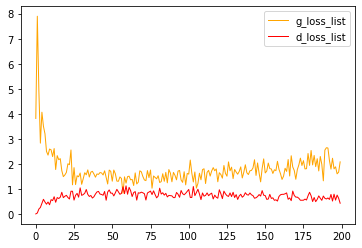

In [19]:
plt.plot(epoch_list, g_loss_list, linewidth=1, color="orange",label="g_loss_list")
plt.plot(epoch_list, d_loss_list, linewidth=1, color="red",label="d_loss_list")
plt.legend()

In [98]:
def buildImage(imgs_t, batch):
    img = 0.5 * (imgs_t + 1).view(batch, 1, 28, 28)
    return img

In [99]:
G = Generator(latent_dim)
G.load_state_dict(torch.load('mnist_generator_new.pt'))

<All keys matched successfully>

In [100]:
z = torch.randn(batch_size, latent_dim)
z.shape

torch.Size([64, 100])

In [101]:
imgs_fake = buildImage(G(z), batch_size)
save_image(imgs_fake, 'images.png', nrow=7, normalize=True)

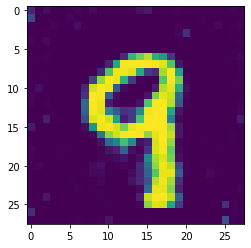

In [134]:
plt.imshow(imgs_fake[28].squeeze(0).detach().numpy())

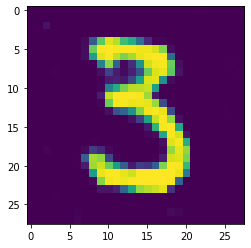

In [135]:
plt.imshow(imgs_fake[41].squeeze(0).detach().numpy())

In [139]:
image_start = z[41].numpy()
image_end = z[28].numpy()

interpolate_list = []

image_step = ((image_end - image_start) / (7 + 2))

for step in range(9):
    image_bias = step * image_step
    interpolate_list.append(image_start + image_bias)
    
interpolate_list_t = torch.Tensor(np.array(interpolate_list))
interpolate_list_t.shape

torch.Size([9, 100])

In [140]:

image_interplate = buildImage(G(interpolate_list_t), 9)
save_image(image_interplate[:9], 'interpolation_image.png', nrow=3, normalize=True)